In [1]:
import numpy as np
import pandas as pd
import yfinance as yf      
import matplotlib.pyplot as plt
import math
from statsmodels.tsa.stattools import adfuller

## Generate Data

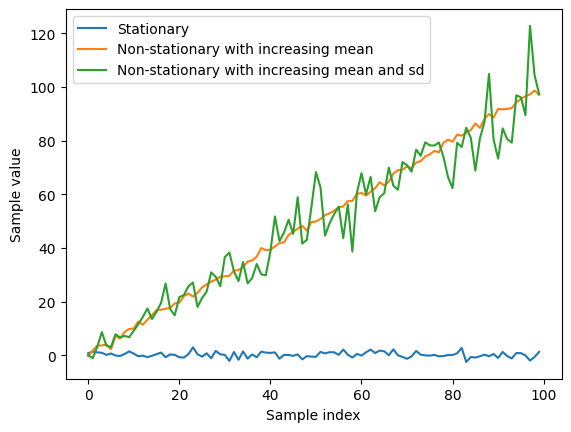

In [2]:
def generate_normal_sample(params):         
    """
    input: params, including mean in params[0] and standard deviation in params[1]
    output: a random sample from the normal distribution parameterized by the input         
    """
    mean = params[0]
    sd = params[1]
    return np.random.normal(mean, sd)


T = 100  
stationary_list, nonstationary_list1, nonstationary_list2 = [], [], []
          
for i in range(T): 
    # generate a stationary sample and append to list     
    stationary_list.append(generate_normal_sample([0,1]))
  
    # generate a non-stationary sample with an increasing mean and append to list  
    nonstationary_list1.append(generate_normal_sample([i,1]))
         
    # # generate a non-stationary sample with an increasing mean and sd and append to list    
    nonstationary_list2.append(generate_normal_sample([i,np.sqrt(i)]))

                        
x = range(T)
          
# plot the lists as line plots with labels for each line          
plt.plot(x, stationary_list, label='Stationary')         
plt.plot(x, nonstationary_list1, label='Non-stationary with increasing mean')          
plt.plot(x, nonstationary_list2, label='Non-stationary with increasing mean and sd')
                
# set the axis labels         
plt.xlabel('Sample index')            
plt.ylabel('Sample value')

# add a legend         
plt.legend()

# show the plot         
plt.show()

## Stationarity Test with ADF

```math
\begin{align}

y_t &= c + B_t + aY_{t-1}+\sum_{i=1}^{t-1}(\phi_i\Delta Y_{t-i})+e_t
\end{align}
```
when a or any $\phi_i$ > 1, it must non stationarity

In [3]:
def stationarity_test(x, threshold=0.05):       
    """            
    input:         
    x: a list of scalar values      
    threshold: significance level
    output: print out message on stationarity
    """
        
    pvalue = adfuller(x)[1]

                
    if pvalue < threshold:        
        return 'p-value is ' + str(pvalue) + '. The series is likely stationary.'
    else:
        return 'p-value is ' + str(pvalue) + '. The series is likely non-stationary.'


print(stationarity_test(stationary_list))                
print(stationarity_test(nonstationary_list1))
print(stationarity_test(nonstationary_list2))

p-value is 4.1416601214697506e-17. The series is likely stationary.
p-value is 0.932696650762961. The series is likely non-stationary.
p-value is 0.9622768615440139. The series is likely non-stationary.


# Pair Trading

In [4]:
import os   
import random
import numpy as np
import yfinance as yf
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
from matplotlib import pyplot as plt
%matplotlib inline

SEED = 8
random.seed(SEED)
np.random.seed(SEED)

start_date  = "2022-01-01"
end_date  = "2022-12-31"
stocks = ['GOOG','MSFT']
df = yf.download(stocks, start=start_date, end=end_date)['Adj Close']

df.head()

[*********************100%***********************]  2 of 2 completed


Ticker,GOOG,MSFT
Date,,
2024-01-02 00:00:00+00:00,139.060333,368.117249
2024-01-03 00:00:00+00:00,139.857483,367.849243
2024-01-04 00:00:00+00:00,137.545761,365.209015
2024-01-05 00:00:00+00:00,136.898117,365.020386
2024-01-08 00:00:00+00:00,140.026855,371.908905


In [5]:
Y = df[stocks[0]]                
X = df[stocks[1]]

X_with_constant = sm.add_constant(X)
model = OLS(Y, X_with_constant).fit()
residuals = Y - model.predict()

print(X[:2])
print(X_with_constant[:2])
print(model.summary())

Date
2024-01-02 00:00:00+00:00    368.117249
2024-01-03 00:00:00+00:00    367.849243
Name: MSFT, dtype: float64
                           const        MSFT
Date                                        
2024-01-02 00:00:00+00:00    1.0  368.117249
2024-01-03 00:00:00+00:00    1.0  367.849243
                            OLS Regression Results                            
Dep. Variable:                   GOOG   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     11.17
Date:                Thu, 12 Dec 2024   Prob (F-statistic):            0.00184
Time:                        12:26:30   Log-Likelihood:                -113.87
No. Observations:                  41   AIC:                             231.7
Df Residuals:                      39   BIC:                             235.2
Df Model:                           1                                       

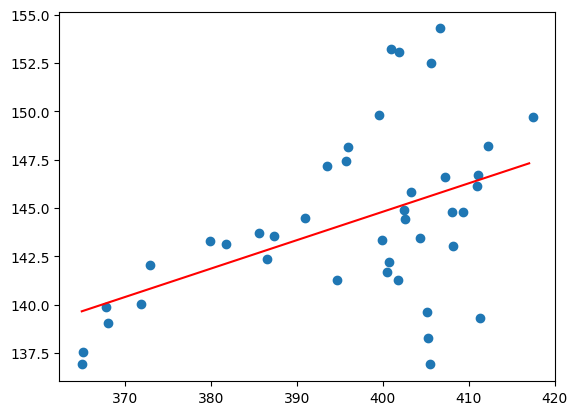

In [6]:
plt.scatter(X,Y)

max_x = X.max()
min_x = X.min()
x = np.arange(min_x, max_x, 1)
y_hat = model.params.iloc[1]*x + model.params.iloc[0];
plt.plot(x,y_hat, 'r')
plt.show()

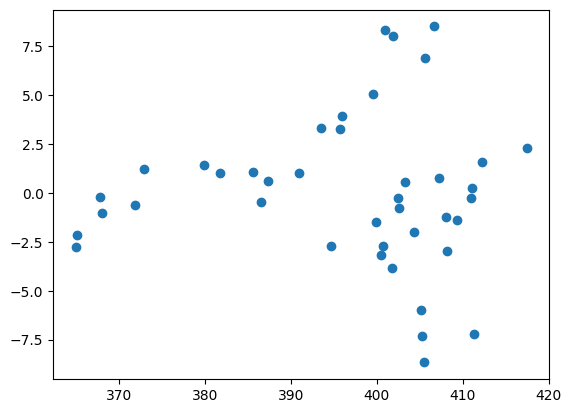

In [7]:
plt.scatter(X,residuals)
plt.show()

Check stationarity

In [8]:
adf_test = adfuller(residuals)
print(f"ADF test statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")
        
if adf_test[1] < 0.05:
    print("The two stocks are cointegrated.")           
else:
    print("The two stocks are not cointegrated.")

ADF test statistic: -1.3883260408262261
p-value: 0.5878597889980497
The two stocks are not cointegrated.


### corelation vs cointegration

Correlation: 0.994833254077976
Cointegration test p-value: 0.17830098966789198


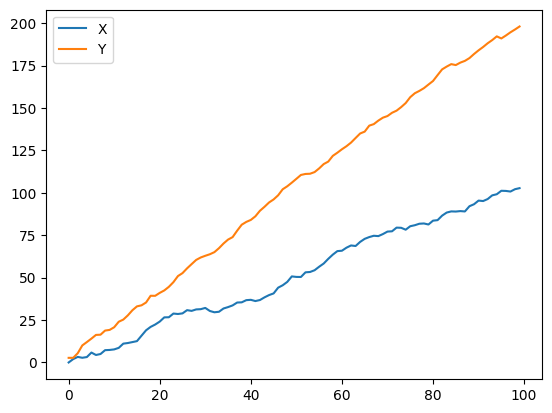

In [9]:
np.random.seed(123)
X = np.random.normal(1, 1, 100)
Y = np.random.normal(2, 1, 100)

                
X = pd.Series(np.cumsum(X), name='X')       
Y = pd.Series(np.cumsum(Y), name='Y')
         
pd.concat([X, Y], axis=1).plot()

from statsmodels.tsa.stattools import coint

                
# calculate the correlation coefficeint
print('Correlation: ' + str(X.corr(Y)))

                
# perform in cointegration test     
score, pvalue, _ = coint(X,Y)          
print('Cointegration test p-value: ' + str(pvalue))


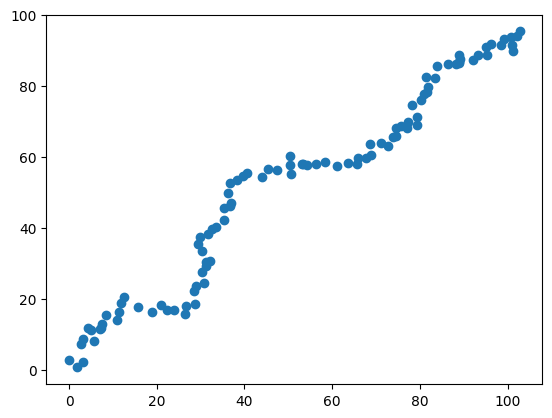

In [10]:
plt.scatter(X,Y-X)

## Implementing the Pairs Trading Strategy
Pairs trading identifies two cointegrated stocks based on a specific statistical test procedure using historical data. No matter whether the market moves up or down for these two stocks, there is no impact on the pairs trading strategy, so long as their relative spread remains the same. Instead, the strategy monitors the spread between the two stocks, which should remain relatively constant over time, and makes a move in case of short-term price movements based on preset thresholds.

In [11]:
stocks = ['GOOG','MSFT','AAPL','TSLA','META','NFLX','AMD','AMZN']
df = yf.download(stocks, start=start_date, end=end_date)['Adj Close']

[*********************100%***********************]  8 of 8 completed


### Identifying Cointegrated Pairs of Stocks

In [12]:
from itertools import combinations
# get all pairs of stocks
stock_pairs = list(combinations(df.columns, 2))

### Testing Pairwise Cointegration

In [13]:
threshold = 0.1 
select_pair=None
temp=threshold-2
# run Engle-Granger test for cointegration on each pair of stocks
for pair in stock_pairs:  
    
    # subset df based on current pair of stocks      
    df2 = df[list(pair)]    

    # perform test for the current pair of stocks           
    score, pvalue, _ = coint(df2.values[:,0], df2.values[:,1])      
    # check if the current pair of stocks is cointegrated   
    if pvalue < threshold:
        if(temp<=pvalue):
            select_pair = pair
            temp = pvalue
        print(pair, f'are cointegrated pvalue {pvalue}')
    else:
        print(pair, 'are not cointegrated')

('AAPL', 'AMD') are not cointegrated
('AAPL', 'AMZN') are not cointegrated
('AAPL', 'GOOG') are not cointegrated
('AAPL', 'META') are not cointegrated
('AAPL', 'MSFT') are not cointegrated
('AAPL', 'NFLX') are not cointegrated
('AAPL', 'TSLA') are not cointegrated
('AMD', 'AMZN') are not cointegrated
('AMD', 'GOOG') are not cointegrated
('AMD', 'META') are not cointegrated
('AMD', 'MSFT') are not cointegrated
('AMD', 'NFLX') are not cointegrated
('AMD', 'TSLA') are not cointegrated
('AMZN', 'GOOG') are not cointegrated
('AMZN', 'META') are cointegrated pvalue 0.01756036755921555
('AMZN', 'MSFT') are not cointegrated
('AMZN', 'NFLX') are cointegrated pvalue 0.05276665619597625
('AMZN', 'TSLA') are not cointegrated
('GOOG', 'META') are not cointegrated
('GOOG', 'MSFT') are not cointegrated
('GOOG', 'NFLX') are not cointegrated
('GOOG', 'TSLA') are not cointegrated
('META', 'MSFT') are not cointegrated
('META', 'NFLX') are not cointegrated
('META', 'TSLA') are not cointegrated
('MSFT', 'N

In [14]:
print(select_pair[0])

AMZN


### Obtaining the Spread

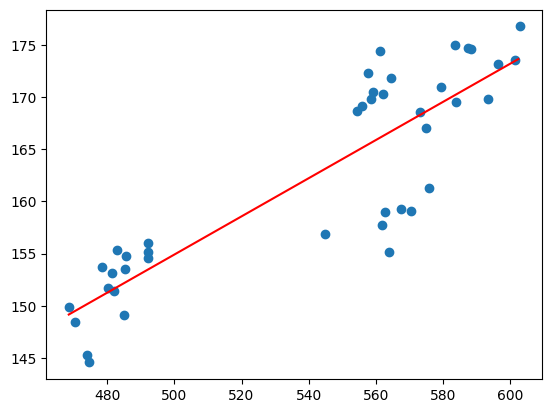

<Axes: xlabel='Date'>

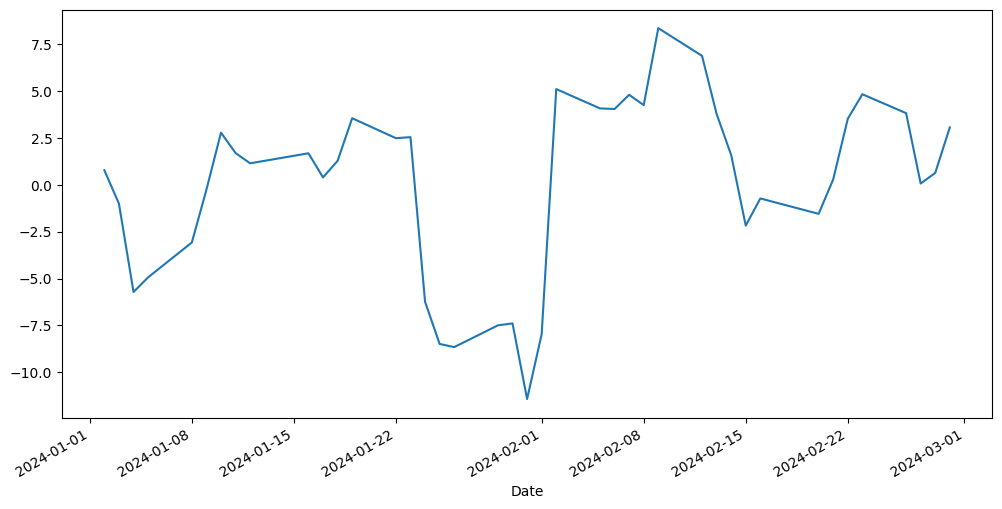

In [15]:
# calculate the spread for GOOG and MSFT
Y = df[select_pair[0]]
X = df[select_pair[1]]

# estimate linear regression coefficients
X_with_constant = sm.add_constant(X)
model = OLS(Y, X_with_constant).fit() # transform msft to match GOOG


plt.scatter(X,Y)
max_x = X.max()
min_x = X.min()
x = np.arange(min_x, max_x, 1)
y_hat = model.params.iloc[1]*x + model.params.iloc[0];
plt.plot(x,y_hat, 'r')
plt.show()


# obtain the spread as the residuals                
spread = Y - model.predict(X_with_constant)#mean line
spread.plot(figsize=(12,6))
##positive msft(stock1) < goog(stock2)
##negative msft(stock1) > goog(stock2)

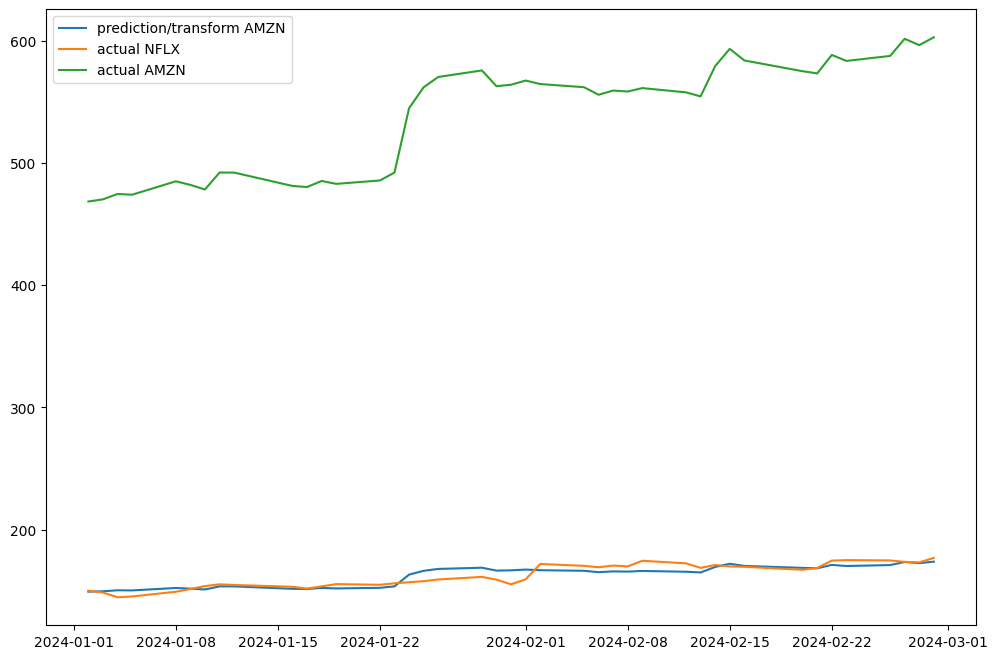

In [24]:
x=X_with_constant.index
y_hat= model.predict(X_with_constant)
plt.figure(figsize=(12,8))
plt.plot(x,y_hat, label=f"prediction/transform {select_pair[0]}")
plt.plot(x,Y, label=f"actual {select_pair[1]}")
plt.plot(x,X, label=f"actual {select_pair[0]}")
plt.legend()
plt.show()


### Converting to Z-Scores

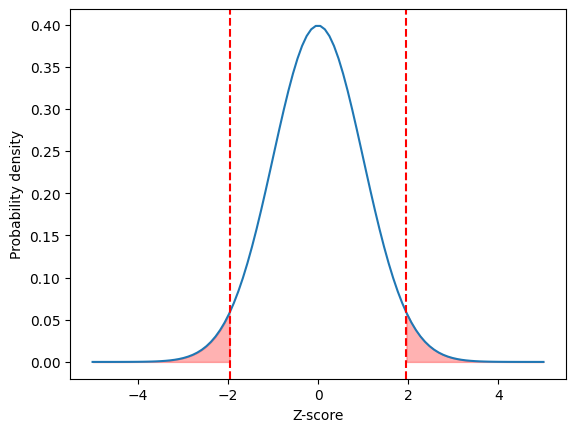

In [17]:
# illustrate z score by generating a standard normal distribution with mu 0 and sd 1
from scipy.stats import norm

# input: unbounded scalar, assumed to be in the range of [-5,-5] in this case
x = np.linspace(-5, 5, 100)

# output: probability between 0 and 1
y = norm.pdf(x, loc=0, scale=1)
  
# set up the plot
fig, ax = plt.subplots()
                
# plot the pdf of normal distribution
ax.plot(x, y)
                
# shade the area corresponding to a z-score of >=1.96 and <=-1.96
z_critical = 1.96
x_shade = np.linspace(z_critical, 5, 100)
y_shade = norm.pdf(x_shade, loc=0, scale=1)
ax.fill_between(x_shade, y_shade, color='red', alpha=0.3)

z_critical2 = -1.96
x_shade2 = np.linspace(-5, z_critical2, 100)
y_shade2 = norm.pdf(x_shade2, loc=0, scale=1)
ax.fill_between(x_shade2, y_shade2, color='red', alpha=0.3)

                
# add labels and a title
ax.set_xlabel('Z-score')
ax.set_ylabel('Probability density')
    
# add a vertical line to indicate the z-score of 1.96 and -1.96
ax.axvline(x=z_critical, linestyle='--', color='red')
ax.axvline(x=z_critical2, linestyle='--', color='red')

# display the plot
plt.show()

<Axes: xlabel='Date'>

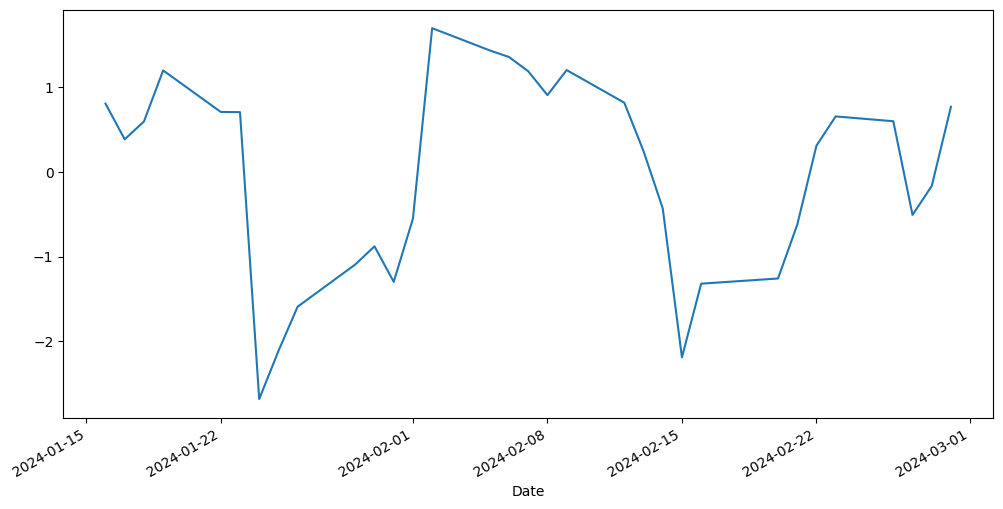

In [18]:
# convert to z score        
# z-score is a measure of how many standard deviations the spread is from its mean           
# derive mean and sd using a moving window
            
window_size = 10          
spread_mean = spread.rolling(window=window_size).mean()             
spread_std = spread.rolling(window=window_size).std()             
zscore = (spread - spread_mean) / spread_std 
zscore.plot(figsize=(12,6))

##positive msft(stock1) > goog(stock2)
##negative msft(stock1) < goog(stock2)

In [19]:
# remove initial days with NA
first_valid_idx = zscore.first_valid_index()     
zscore = zscore[first_valid_idx:]

In [20]:
# set the threshold values for entry and exit signals
entry_threshold = 2.0                
exit_threshold = 1.0

                
# initialize the daily positions to be zeros       
stock1_position = pd.Series(data=0, index=zscore.index)
stock2_position = pd.Series(data=0, index=zscore.index)

                
# generate daily entry and exit signals for each stock
for i in range(1, len(zscore)):

    # zscore<-2 and no existing long position for stock 1        
    if zscore.iloc[i] < -entry_threshold and stock1_position.iloc[i-1] == 0: #
        stock1_position.iloc[i] = 1 # long stock 1
        stock2_position.iloc[i] = -1 # short stock 2

                
    # zscore>2 and no existing short position for stock 2
    elif zscore.iloc[i] > entry_threshold and stock2_position.iloc[i-1] == 0: 
        stock1_position.iloc[i] = -1 # short stock 1
        stock2_position.iloc[i] = 1 # long stock 2

                
    # -1<zscore<1
    elif abs(zscore.iloc[i]) < exit_threshold:
        stock1_position.iloc[i] = 0 # exit existing position
        stock2_position.iloc[i] = 0
    # -2<zscore<-1 or 1<zscore<2       
    else:
        stock1_position.iloc[i] = stock1_position.iloc[i-1] # maintain existing position
        stock2_position.iloc[i] = stock2_position.iloc[i-1]


<Axes: xlabel='Date'>

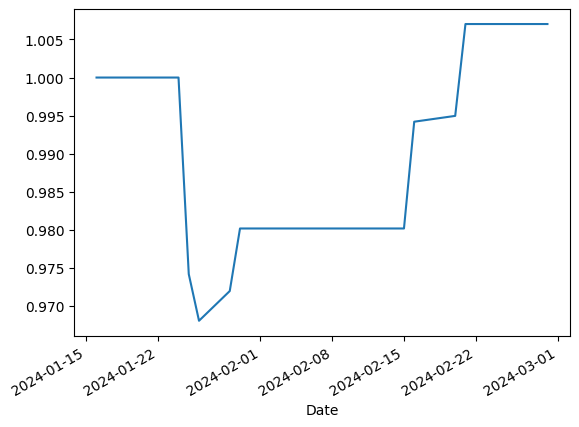

In [ ]:
# Calculate the returns of each stock
stock1_returns = (df[select_pair[0]][first_valid_idx:].pct_change() * stock1_position.shift(1)).fillna(0)          
stock2_returns = (df[select_pair[1]][first_valid_idx:].pct_change() * stock2_position.shift(1)).fillna(0)

                
# calculate the total returns of the strategy        
total_returns = stock1_returns + stock2_returns         
cumulative_returns = (1 + total_returns).cumprod()
cumulative_returns.plot()


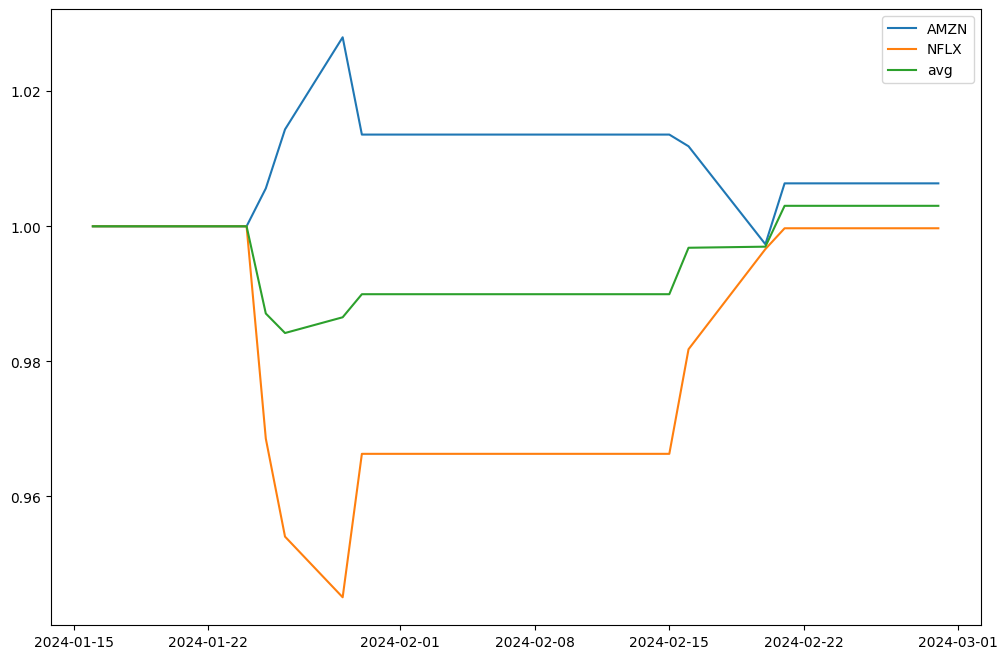

In [37]:
cum1 = (1+stock1_returns).cumprod()
cum2 = (1+stock2_returns).cumprod()
avg=((cum1+cum2)/2)

plt.figure(figsize=(12,8))
plt.plot(cum1, label=f"{select_pair[0]}")
plt.plot(cum2, label=f"{select_pair[1]}")
plt.plot(avg,  label=f"avg")
plt.legend()
plt.show()

### Reference 

1. [link1](https://zhuanlan.zhihu.com/p/21566798)
1. [link2](https://www.heywhale.com/mw/project/6593c8367f7f3f8921363d60)